<a href="https://colab.research.google.com/github/Cigems/dbt-xkcd-project/blob/main/dbtxkcd_project_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snowflake-connector-python pandas matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 7.5 MB/s eta 0:00:00


In [ ]:
import snowflake.connector

# Define Snowflake connection parameters
conn = snowflake.connector.connect(
    user="CIGDEMS",
    password="****",
    account="DNXZLRR-QW11335",
    warehouse="COMPUTE_WH",
    database="XKCD_DB",
    schema="DBT_ANALYTICS"
)

# Test connection
cur = conn.cursor()
cur.execute("SELECT CURRENT_VERSION()")
print("Snowflake Version:", cur.fetchone()[0])


Snowflake Version: 9.6.0


<ipython-input-16-bc2b11f27e79>:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


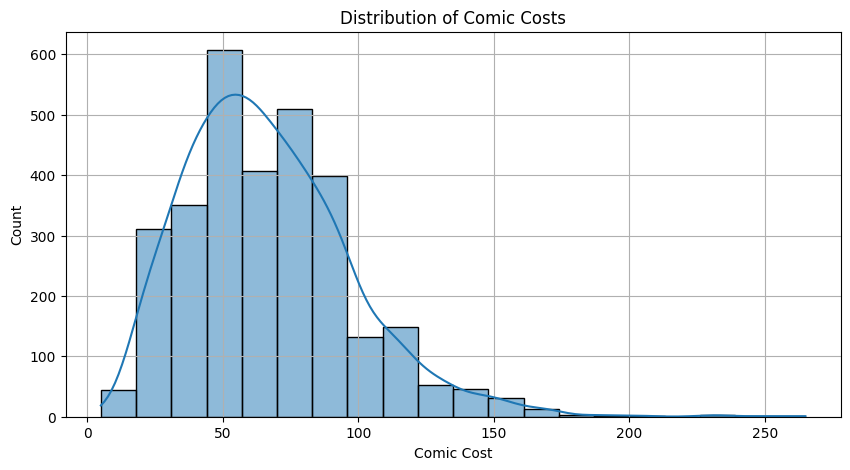

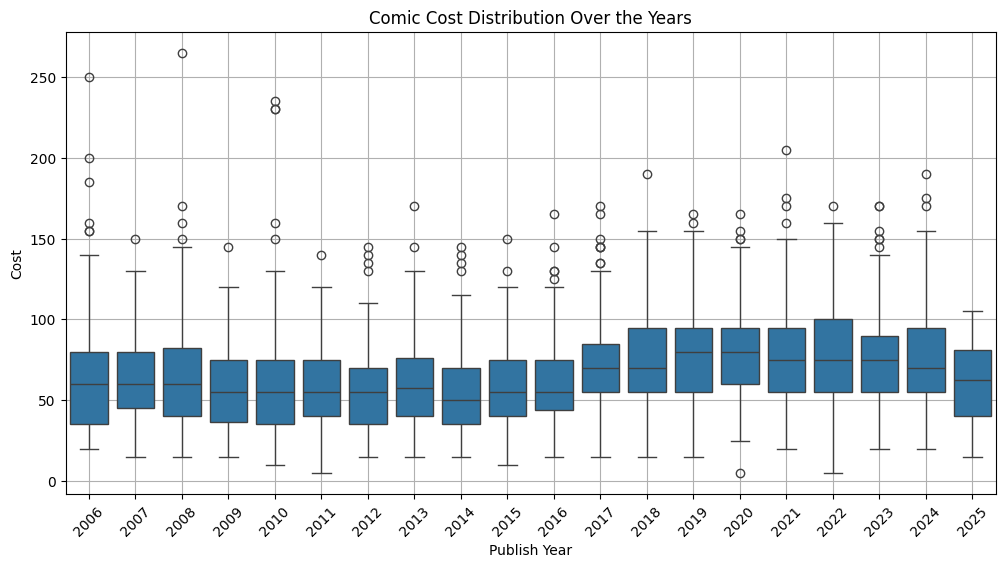

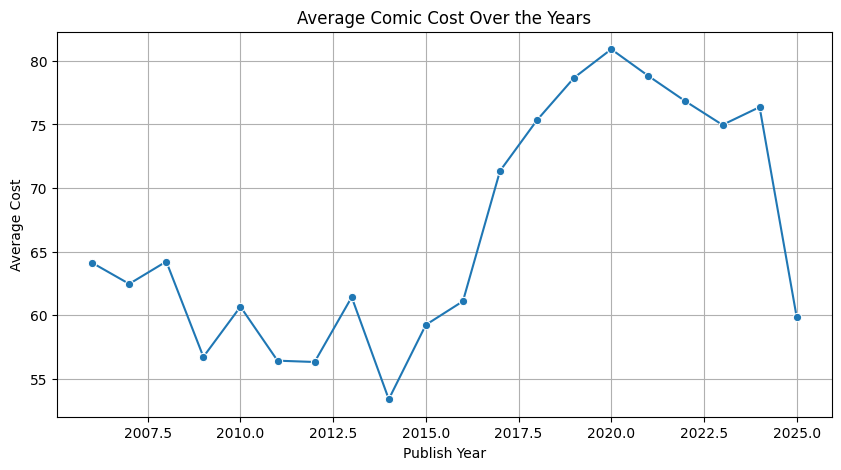

In [ ]:
# 1st use case: I would like to see the distribution of comics cost. What is our average comic cost? Did it change over the years?

query = """
SELECT COST, PUBLISH_YEAR, PUBLISH_DAY
FROM xkcd_db.dbt_ANALYTICS.dim_comics
"""
df = pd.read_sql(query, conn)


plt.figure(figsize=(10,5))
sns.histplot(df["COST"], bins=20, kde=True)
plt.xlabel("Comic Cost")
plt.ylabel("Count")
plt.title("Distribution of Comic Costs")
plt.grid(True)
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(x=df["PUBLISH_YEAR"], y=df["COST"])
plt.xticks(rotation=45)
plt.xlabel("Publish Year")
plt.ylabel("Cost")
plt.title("Comic Cost Distribution Over the Years")
plt.grid(True)
plt.show()


df_yearly = df.groupby("PUBLISH_YEAR")["COST"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x=df_yearly["PUBLISH_YEAR"], y=df_yearly["COST"], marker="o")
plt.xlabel("Publish Year")
plt.ylabel("Average Cost")
plt.title("Average Comic Cost Over the Years")
plt.grid(True)
plt.show()




<ipython-input-23-f1eb53b6b8be>:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


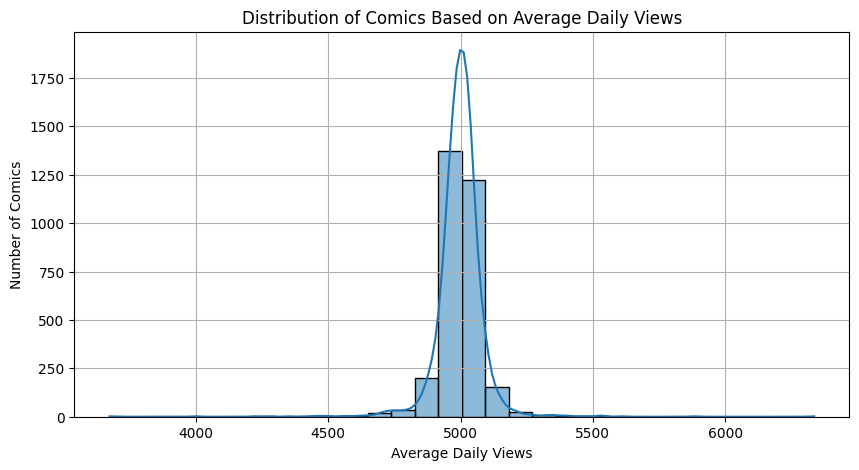

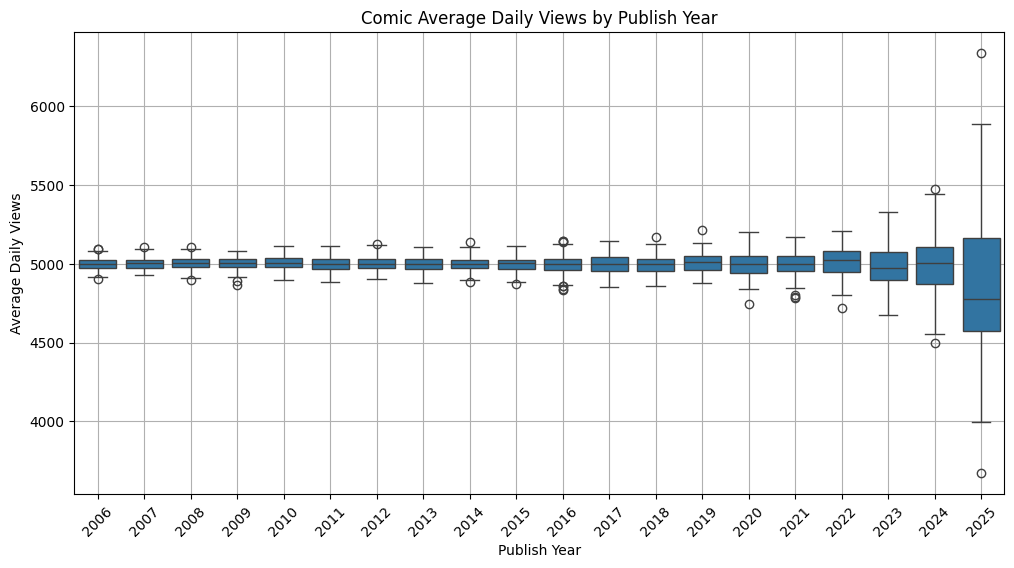

In [ ]:
# 2nd use case: I would like to see the distribution of comics based on avg daily views, and how it changed over the years.
query = """
SELECT
    f.COMIC_ID,
    d.PUBLISH_YEAR,
    AVG(f.VIEWS) AS avg_daily_views
FROM xkcd_db.dbt_ANALYTICS.fact_comic_stats f
JOIN xkcd_db.dbt_ANALYTICS.dim_comics d
ON f.COMIC_ID = d.COMIC_ID
GROUP BY f.COMIC_ID, d.PUBLISH_YEAR


"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
sns.histplot(df["AVG_DAILY_VIEWS"], bins=30, kde=True)
plt.xlabel("Average Daily Views")
plt.ylabel("Number of Comics")
plt.title("Distribution of Comics Based on Average Daily Views")
plt.grid(True)
plt.show()



plt.figure(figsize=(12,6))
sns.boxplot(x=df["PUBLISH_YEAR"], y=df["AVG_DAILY_VIEWS"])
plt.xticks(rotation=45)
plt.xlabel("Publish Year")
plt.ylabel("Average Daily Views")
plt.title("Comic Average Daily Views by Publish Year")
plt.grid(True)
plt.show()



<ipython-input-27-8f994640a94b>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


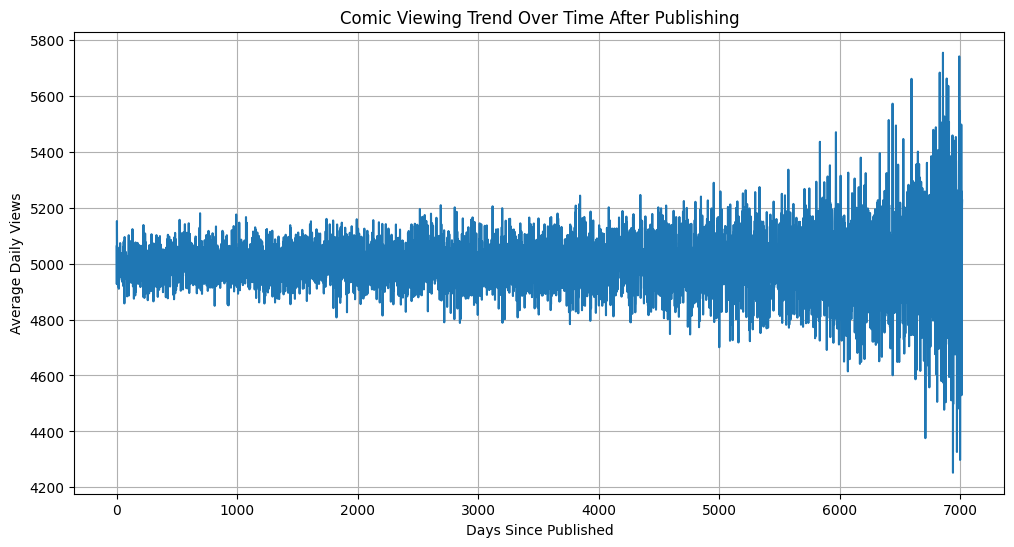

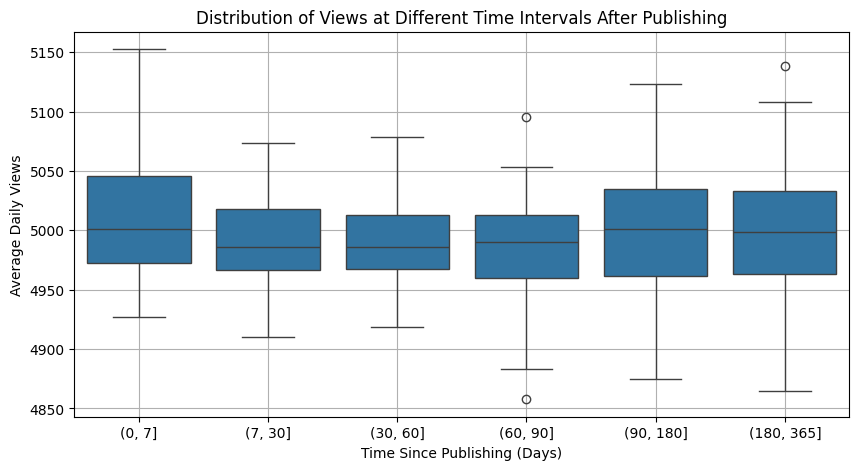

In [ ]:
# 3rd use case: I would like to see the avg views over time after publishing

query = """
SELECT
    DAYS_SINCE_PUBLISHED,
    AVG(VIEWS) AS avg_views_per_day
FROM xkcd_db.dbt_ANALYTICS.fact_comic_stats
GROUP BY DAYS_SINCE_PUBLISHED
ORDER BY DAYS_SINCE_PUBLISHED



"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(12,6))
sns.lineplot(x=df["DAYS_SINCE_PUBLISHED"], y=df["AVG_VIEWS_PER_DAY"])
plt.xlabel("Days Since Published")
plt.ylabel("Average Daily Views")
plt.title("Comic Viewing Trend Over Time After Publishing")
plt.grid(True)
plt.show()


df_filtered = df[df["DAYS_SINCE_PUBLISHED"] <= 365]  # Focus on the first year

plt.figure(figsize=(10,5))
sns.boxplot(x=pd.cut(df_filtered["DAYS_SINCE_PUBLISHED"], bins=[0,7,30,60,90,180,365]),
            y=df_filtered["AVG_VIEWS_PER_DAY"])
plt.xlabel("Time Since Publishing (Days)")
plt.ylabel("Average Daily Views")
plt.title("Distribution of Views at Different Time Intervals After Publishing")
plt.grid(True)
plt.show()



<ipython-input-28-d765ca469ea8>:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


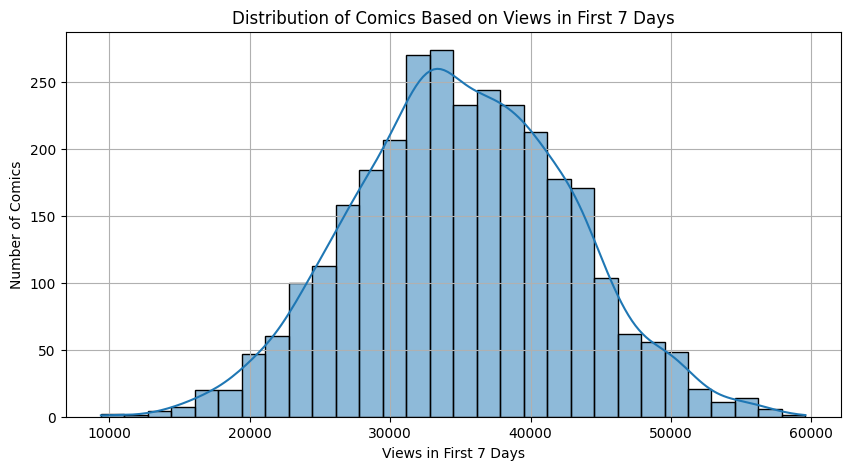

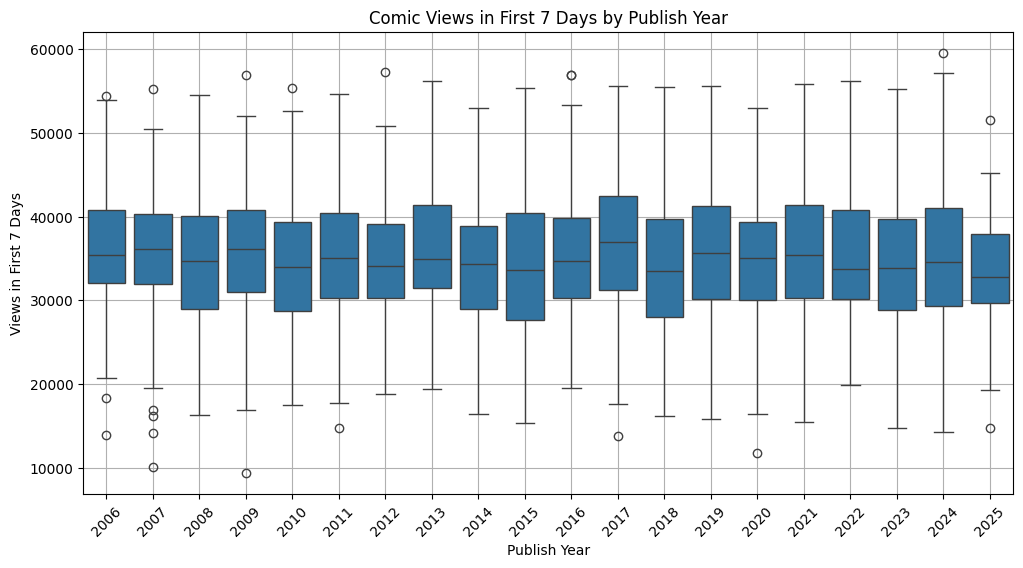

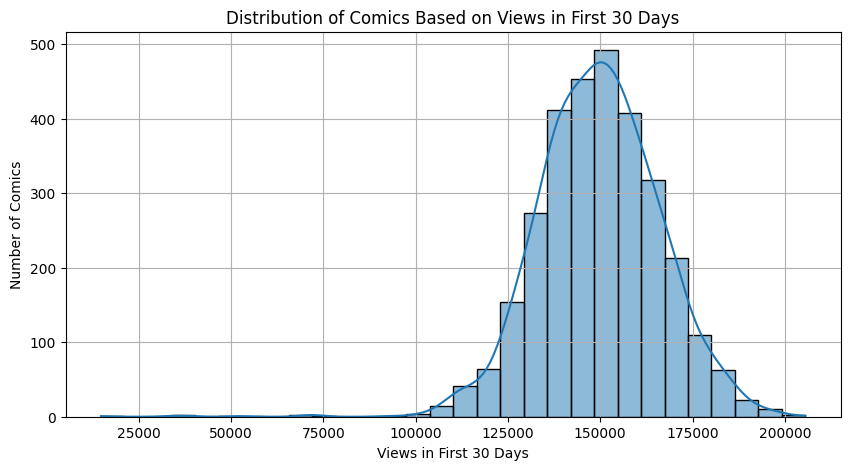

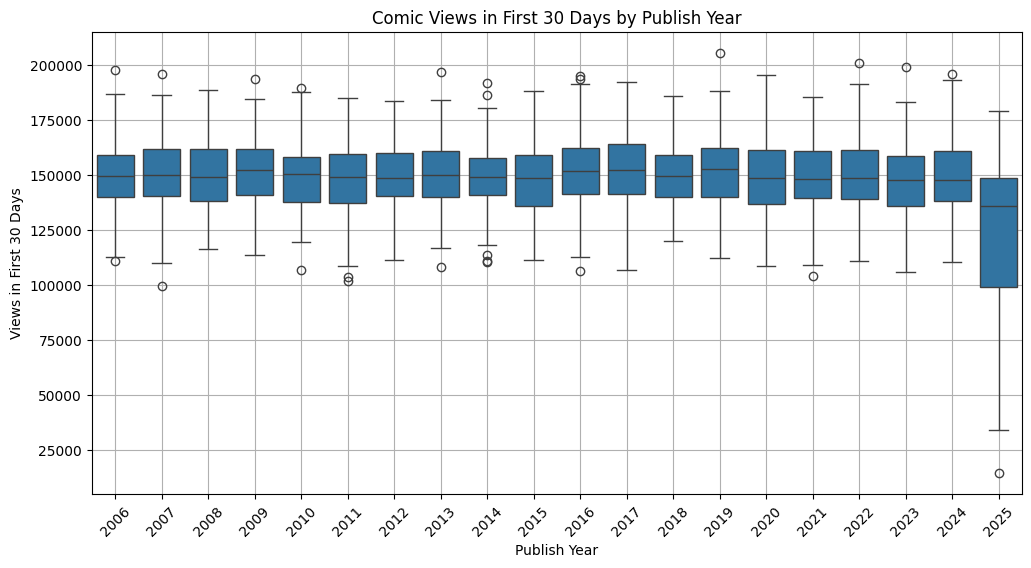

In [ ]:
# 4th use case: Analyze the first 7 days and first 30 days views over the time

query = """
SELECT
    f.COMIC_ID,
    d.PUBLISH_YEAR,
    f.VIEWS_7D,
    f.VIEWS_30D
FROM xkcd_db.dbt_ANALYTICS.fact_comic_performance f
JOIN xkcd_db.dbt_ANALYTICS.dim_comics d
ON f.COMIC_ID = d.COMIC_ID

"""
df = pd.read_sql(query, conn)


plt.figure(figsize=(10,5))
sns.histplot(df["VIEWS_7D"], bins=30, kde=True)
plt.xlabel("Views in First 7 Days")
plt.ylabel("Number of Comics")
plt.title("Distribution of Comics Based on Views in First 7 Days")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=df["PUBLISH_YEAR"], y=df["VIEWS_7D"])
plt.xticks(rotation=45)
plt.xlabel("Publish Year")
plt.ylabel("Views in First 7 Days")
plt.title("Comic Views in First 7 Days by Publish Year")
plt.grid(True)
plt.show()



plt.figure(figsize=(10,5))
sns.histplot(df["VIEWS_30D"], bins=30, kde=True)
plt.xlabel("Views in First 30 Days")
plt.ylabel("Number of Comics")
plt.title("Distribution of Comics Based on Views in First 30 Days")
plt.grid(True)
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(x=df["PUBLISH_YEAR"], y=df["VIEWS_30D"])
plt.xticks(rotation=45)
plt.xlabel("Publish Year")
plt.ylabel("Views in First 30 Days")
plt.title("Comic Views in First 30 Days by Publish Year")
plt.grid(True)
plt.show()
